<a href="https://colab.research.google.com/github/Visionlogic-AI/Object_Detection_Projects/blob/master/How_to_Train_Mask_R_CNN_Model_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In order to train the mask r-cnn model on the dataset that we prepared, we must first download the model weights,

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install mrcnn
!git clone https://github.com/matterport/Mask_RCNN.git
!git clone http://github.com/experiencor/kangaroo.git

     |████████████████████████████████| 61kB 3.3MB/s 
  Created wheel for mrcnn: filename=mrcnn-0.2-cp36-none-any.whl size=54931 sha256=0f3eb2ca05a884d99521958522a467d2d714fa48af7f0417830133c3ef642b4f
  Stored in directory: /root/.cache/pip/wheels/11/ed/28/e550ddc897c04c336b923eae4eb35c9aae993d20ce39d9cc40
Successfully built mrcnn
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.84 MiB | 31.34 MiB/s, done.
Resolving deltas: 100% (570/570), done.
Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 54.58 MiB/s, done.
Resolving deltas: 100% (158/158), done.


In [0]:
!git clone http://github.com/waleedka/coco

Cloning into 'coco'...
remote: Enumerating objects: 904, done.
remote: Total 904 (delta 0), reused 0 (delta 0), pack-reused 904
Receiving objects: 100% (904/904), 10.39 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (539/539), done.


In [0]:
!pip install opencv-python
import os 
import imgaug
import sys 
import re 
import random
import math
import cv2
import time
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
from  pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import zipfile
import urllib.request
import shutil


#Root directory of the project
ROOT_DIR= os.path.abspath('../..')

import warnings
warnings.filterwarnings('ignore')

#import maskrcnn
sys.path.append(ROOT_DIR)   #to find local version
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

#import coco configuration
sys.path.append(os.path.join(ROOT_DIR, 'samples/coco/'))  #to find local version
import coco

%matplotlib inline

#Directory to save logs and trained model
MODEL_DIR= os.path.join(ROOT_DIR, 'logs')
#path for downloaded coco weights
COCO_MODEL_PATH= os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
#path for downloaded coco weights for releases if needed
if not os.path.exists(COCO_MODEL_PATH):
  utils.download_trained_weights(COCO_MODEL_PATH)

#Directory of images to run detection
IMAGE_DIR= os.path.join(ROOT_DIR, 'ima')

Using TensorFlow backend.


... done downloading pretrained model!


### Create an Inference Class

In [0]:
from os import listdir
import numpy as np
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from mrcnn.config import Config
from mrcnn.model import MaskRCNN


#Phase 1
#class that defines and loads thr kangaroo dataset
class KangarooDataset(Dataset):
    #load the dataset definitions
    def load_dataset(self, dataset_dir, is_train= True):
        #define one class
        self.add_class('dataset', 1, 'kangaroo')
        #define data locations
        images_dir= dataset_dir + '/images/'
        annotations_dir= dataset_dir + '/annots/'
        #find all images
        for filename in listdir(images_dir):
            #extract image id
            image_id= filename[:-4]
            #skip bad images
            if image_id in ['00090']:
                continue
            #if skip all images after 15 if we are building train dataset
            if is_train and int(image_id) >= 150: #great than or equal to
                continue
            #skip all image before the 150 for test/val dataset
            if not is_train and int(image_id) < 150:  #less than 150
                continue
            img_path= images_dir + filename
            ann_path= annotations_dir + image_id + '.xml'
            #add to dataset
            self.add_image('dataset', image_id=image_id, path= img_path, annotation= ann_path)
    
    #extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        #load and parse the file
        tree= ElementTree.parse(filename)
        #get the the root of the document
        root= tree.getroot()
        #extract bounding boxes
        boxes= list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors= [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            #extract image dimensions
            width= int(root.find('.//size/width').text)
            height= int(root.find('.//size/height').text)
            return boxes, width, height
    
    #Load the mask for the image
    def load_mask(self, image_id):
        info= self.image_info[image_id]
        dataset= info['dataset']
        count= len(dataset)
        mask= np.zeros([info['height'], info['width'], 3], dtype=np.uint8)
        for i, (dataset), in enumerate(info['dataset']):
          mask[:, :, i:i + 1] = self.draw_shape(mask[:, :, i:i + 1].copy(), 
                                                dataset, 1)
        #handle occlusions
        occlusion= np.logical_not(mask[:, :, i:i -1]).astype(np.uint8)
        for i in range(count- 2, -1, -1):
          mask[:, :, i]= mask[:, :, i] * occlusion
          occlusion= np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
          #maps class names to class ids
          class_ids= np.array([self.class_names_.index(s[0]) for s in datasets])
          return mask.astype(np.bool), class_ids.astype(np.int32)

    
    #load an image reference
    def image_reference(self, image_id):
        info= self.image_info[image_id]
        return info['path']
    

#Phase 2 (ensure model weights have been downloaded)
#this is a new class that extends the mrcnn.config.Config class
#define class
class KangarooConfig(Config):
    #give configuration a recognizable nam
    NAME = 'kangaroo.cfg'
    GPU_COUNT= 1
    IMAGES_PER_GPU= 1
    IMAGE_MIN_DIM= 128
    IMAGE_MAX_DIM= 128
    RPN_ANCHOR_SCALES= (8,16,32,64,128)
    TRAIN_ROIS_PER_IMAGE= 32
    #number of classes (background + kangaroo)
    NUM_CLASSES= 1 + 1
    VALIDATION_STEPS= 5
    #number of training steps per epoch
    STEP_PER_EPOCH= 131

config= KangarooConfig()
config.display()
    
#prepare train set
train_set = KangarooDataset()
train_set.load_dataset('kangaroo', is_train= True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

#prepare test/val set
test_set= KangarooDataset()
test_set.load_dataset('kangaroo', is_train= False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

#define our model
model = modellib.MaskRCNN(mode='training', model_dir= MODEL_DIR, config= config)

#which weights to start with
init_with= 'coco' 
if init_with== 'imagenet':
  model.load_weights(model_get_imagenet_weights(), by_name= True)
elif init_with=='coco':
  #load weights trained ms coco but skip layers that are different
  model.load_weights(COCO_MODEL_PATH, by_name= True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc',
                                                            'mrcnn_bbox', 'mrcnn_mask'])
elif init_with== 'last':
  #load the last model you trained and continue training
  model.load_weights(model.find_last(), by_name= True)


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES

Once model weights have been loaded, we can train these weights on the **"training datset**".

In [0]:
#Transfer learning, fine tuning only the header layers
#now fit the model on the training dataset
model.train(train_set, test_set, learning_rate= config.LEARNING_RATE, epochs= 5, layers= 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /logs/kangaroo.cfg20200321T1919/mask_rcnn_kangaroo.cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

ERROR:root:Error processing image {'id': '00158', 'source': 'dataset', 'path': 'kangaroo/images/00158.jpg', 'annotation': 'kangaroo/annots/00158.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1219, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-13-ac7c6f4fbef1>", line 62, in load_mask
    dataset= info['dataset']
KeyError: 'dataset'
ERROR:root:Error processing image {'id': '00158', 'source': 'dataset', 'path': 'kangaroo/images/00158.jpg', 'annotation': 'kangaroo/annots/00158.xml'}
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1704, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/usr/local/lib/python3.6/dist-packages/mrcnn/model.py", line 1219, in load_image_gt
    mask, class

KeyError: ignored

#FINE TUNE ALL LAYERS
Passing layers='all' which now trains all layers.
You can also pass the regular expression to select which layers to train by name pattern.

###DETECTION
Typcially you have to save the weights manually but seeing that we save the weights at the end of  every epoch, this is not needed.

In [0]:
class InferenceConfig(KangarooConfig):
  GPU_COUNT= 1
  IMAGES_PER_GPU= 1

inference_config= InferenceConfig()

#recreate model inference mode making predictions...not training
model= modellib.MaskRCNN(mode = 'inference', model_dir= MODEL_DIR, config= inference_config)

#get path to saved weights
#in this case all we have to do is find the path of the last trained weight we set up earlier
model_path= os.path.join(ROOT_DIR, 'mask_rcnn_coco.h5')
#model_path= model.find_last()

#loade "TRAINED" weights
print('Loading weights from', model_path)
model.load_weights(model_path, by_name= True, exclude=['mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask', 'mrcnn_class_logits'])

Loading weights from /mask_rcnn_coco.h5


### Test ON RANDOM IMAGE

original_image           shape: (128, 128, 3)         min:    0.00000  max:  251.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  800.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   23.00000  max:  111.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  uint8


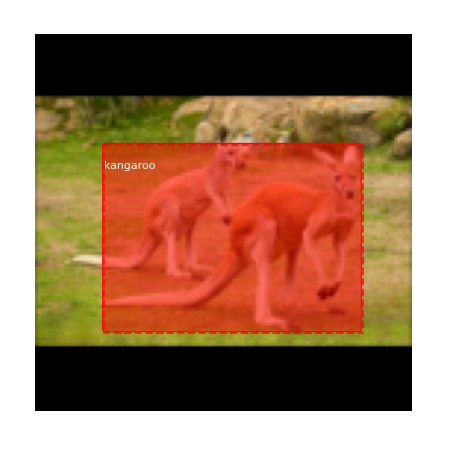

In [0]:
image_id = random.choice(test_set.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(test_set, inference_config,
                         image_id, use_mini_mask= False)
log('original_image', original_image)
log('image_meta', image_meta)
log('gt_class_id', gt_class_id)
log('gt_bbox', gt_bbox)
log('gt_mask', gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                          train_set.class_names, figsize=(8,8))


In [0]:
def get_ax(row=1, col=1, size= 8):
  _, ax= plt.subplots(row, col, figsize= (size*col, size*row))
  return ax

results= model.detect([original_image], verbose= 1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            train_set.class_names, r['scores'], ax= get_ax())